In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
import xgboost as xgb

In [3]:
raw_df = pd.read_csv('heart.csv')

In [4]:
raw_df.shape

(918, 12)

In [ ]:
Ext

In [5]:
raw_df.columns = raw_df.columns.str.lower()

In [6]:
raw_df.columns 

Index(['age', 'sex', 'chestpaintype', 'restingbp', 'cholesterol', 'fastingbs',
       'restingecg', 'maxhr', 'exerciseangina', 'oldpeak', 'st_slope',
       'heartdisease'],
      dtype='object')

In [7]:
raw_df.isnull().sum()

age               0
sex               0
chestpaintype     0
restingbp         0
cholesterol       0
fastingbs         0
restingecg        0
maxhr             0
exerciseangina    0
oldpeak           0
st_slope          0
heartdisease      0
dtype: int64

In [8]:
raw_df.heartdisease.value_counts(normalize=True)

heartdisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

In [9]:
raw_df.heartdisease.mean()

0.5533769063180828

In [10]:
raw_df.nunique()

age                50
sex                 2
chestpaintype       4
restingbp          67
cholesterol       222
fastingbs           2
restingecg          3
maxhr             119
exerciseangina      2
oldpeak            53
st_slope            3
heartdisease        2
dtype: int64

In [11]:
raw_df.age.value_counts()

age
54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: count, dtype: int64

# Data Scaling 

In [12]:

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

raw_df['oldpeak'] = mms.fit_transform(raw_df[['oldpeak']])
raw_df['age'] = ss.fit_transform(raw_df[['age']])
raw_df['restingbp'] = ss.fit_transform(raw_df[['restingbp']])
raw_df['cholesterol'] = ss.fit_transform(raw_df[['cholesterol']])
raw_df['maxhr'] = ss.fit_transform(raw_df[['maxhr']])
raw_df.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,0.295455,Up,0
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,0.409091,Flat,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,0.295455,Up,0
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,0.465909,Flat,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,0.295455,Up,0


# Feature Analysis 

In [13]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
len(df_train), len(df_val), len(df_test)

(550, 184, 184)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [17]:
df_full_train.head(5)

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
852,-1.114921,M,ASY,-0.669935,-0.199402,0,LVH,-0.660578,Y,0.579545,Flat,1
121,-0.160265,F,NAP,-0.399724,0.669570,0,Normal,0.086088,N,0.295455,Up,0
664,1.218683,F,ASY,0.951331,0.239657,0,LVH,-0.896367,N,0.409091,Flat,1
187,-1.327067,M,ASY,-0.669935,0.349422,1,Normal,0.046790,Y,0.409091,Flat,1
108,-0.372411,M,ASY,0.410909,-0.638462,0,Normal,-0.071105,N,0.295455,Up,0


In [18]:
df_full_train.heartdisease.value_counts()

heartdisease
1    398
0    336
Name: count, dtype: int64

In [19]:
mutual_col = list(df_train.columns)
mutual_col

['age',
 'sex',
 'chestpaintype',
 'restingbp',
 'cholesterol',
 'fastingbs',
 'restingecg',
 'maxhr',
 'exerciseangina',
 'oldpeak',
 'st_slope']

# Convert qualitative data to quantitative

In [20]:
categorical_columns = list(df_full_train.dtypes[df_full_train.dtypes == 'object'].index)
categorical_columns

['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope']

In [21]:
numerical_columns = list(df_full_train.dtypes[df_full_train.dtypes != 'object'].index)
numerical_columns

['age',
 'restingbp',
 'cholesterol',
 'fastingbs',
 'maxhr',
 'oldpeak',
 'heartdisease']

In [22]:
le = LabelEncoder() 
df_full_train[categorical_columns] = df_full_train[categorical_columns].apply(lambda col: le.fit_transform(col)) 
df_full_train.head(5)

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
852,-1.114921,1,0,-0.669935,-0.199402,0,0,-0.660578,1,0.579545,1,1
121,-0.160265,0,2,-0.399724,0.669570,0,1,0.086088,0,0.295455,2,0
664,1.218683,0,0,0.951331,0.239657,0,0,-0.896367,0,0.409091,1,1
187,-1.327067,1,0,-0.669935,0.349422,1,1,0.046790,1,0.409091,1,1
108,-0.372411,1,0,0.410909,-0.638462,0,1,-0.071105,0,0.295455,2,0


In [23]:
mutual_scores = []
for c in  df_full_train[mutual_col].columns: 
    score = round(mutual_info_score(df_full_train.heartdisease,df_full_train[c]),3)
    mutual_scores.append(score)
    print(f"mutual score for {c} is {score}")

mutual score for age is 0.087
mutual score for sex is 0.046
mutual score for chestpaintype is 0.152
mutual score for restingbp is 0.071
mutual score for cholesterol is 0.26
mutual score for fastingbs is 0.031
mutual score for restingecg is 0.007
mutual score for maxhr is 0.172
mutual score for exerciseangina is 0.123
mutual score for oldpeak is 0.132
mutual score for st_slope is 0.184


C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continu

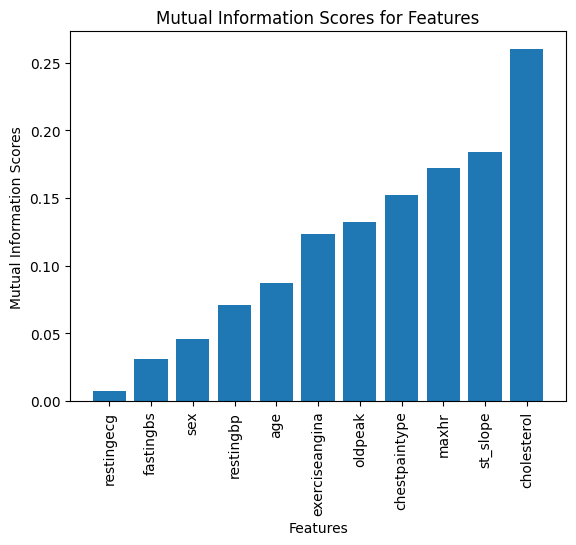

In [24]:
import matplotlib.pyplot as plt

sorted_mutual_scores, sorted_mutual_col_names = zip(*sorted(zip(mutual_scores, mutual_col)))
plt.bar(sorted_mutual_col_names, sorted_mutual_scores)
plt.xlabel("Features")
plt.ylabel("Mutual Information Scores")
plt.title("Mutual Information Scores for Features")
plt.xticks(rotation='vertical')
plt.show()

# Feature importance: Heartdisease rate and risk ratio

In [25]:
for column in categorical_columns:
    unique_categories = df_full_train[column].unique() # this is important
    print(f"Heart disease rate for {column}:")
    for category in unique_categories:
        mean = df_full_train[df_full_train[column] == category].heartdisease.mean()
        print(f"{category}: {mean}")
    print("\n")

Heart disease rate for sex:
1: 0.6204506065857885
0: 0.25477707006369427


Heart disease rate for chestpaintype:
0: 0.7741116751269036
2: 0.34523809523809523
3: 0.48717948717948717
1: 0.12030075187969924


Heart disease rate for restingecg:
0: 0.5197368421052632
1: 0.5114678899082569
2: 0.6575342465753424


Heart disease rate for exerciseangina:
1: 0.8379310344827586
0: 0.3490990990990991


Heart disease rate for st_slope:
1: 0.8096514745308311
2: 0.2111801242236025
0: 0.717948717948718




# Risk Ratio

In [26]:
global_heartdisease = df_full_train.heartdisease.mean()

In [27]:
for c in categorical_columns:
    print(c)
    df_group = df_full_train.groupby(c).heartdisease.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] -global_heartdisease
    df_group['risk'] = df_group['mean'] /global_heartdisease
    df_group
    print(df_group)
    print()

sex
         mean  count      diff      risk
sex                                     
0    0.254777    157 -0.287457  0.469865
1    0.620451    577  0.078216  1.144248

chestpaintype
                   mean  count      diff      risk
chestpaintype                                     
0              0.774112    394  0.231877  1.427633
1              0.120301    133 -0.421934  0.221861
2              0.345238    168 -0.196996  0.636695
3              0.487179     39 -0.055055  0.898467

restingecg
                mean  count      diff      risk
restingecg                                     
0           0.519737    152 -0.022497  0.958510
1           0.511468    436 -0.030766  0.943260
2           0.657534    146  0.115300  1.212639

exerciseangina
                    mean  count      diff      risk
exerciseangina                                     
0               0.349099    444 -0.193135  0.643816
1               0.837931    290  0.295697  1.545330

st_slope
              mean  count

# Feature importance:Correlation

In [28]:
numeric_columns = list(df_full_train.dtypes[df_full_train.dtypes != 'object'].index)
numeric_columns

['age',
 'sex',
 'chestpaintype',
 'restingbp',
 'cholesterol',
 'fastingbs',
 'restingecg',
 'maxhr',
 'exerciseangina',
 'oldpeak',
 'st_slope',
 'heartdisease']

In [29]:
data_numeric = df_full_train[numeric_columns]
data_numeric.describe()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,-0.012572,0.786104,0.798365,0.007654,-0.014130,0.230245,0.991826,0.017129,0.395095,0.391566,1.385559,0.542234
std,0.988265,0.410334,0.968929,0.960763,1.016900,0.421277,0.637559,0.990629,0.489205,0.118581,0.586207,0.498553
min,-2.706015,0.000000,0.000000,-2.831621,-1.818435,0.000000,0.000000,-3.018469,0.000000,0.000000,0.000000,0.000000
25%,-0.690629,1.000000,0.000000,-0.669935,-0.261145,0.000000,1.000000,-0.660578,0.000000,0.295455,1.000000,0.000000
50%,0.051881,1.000000,0.000000,-0.129513,0.212216,0.000000,1.000000,0.105737,0.000000,0.352273,1.000000,1.000000
75%,0.688318,1.000000,2.000000,0.410909,0.621548,0.000000,1.000000,0.754157,1.000000,0.465909,2.000000,1.000000
max,2.491558,1.000000,3.000000,3.653439,3.697252,1.000000,2.000000,2.561874,1.000000,1.000000,2.000000,1.000000


In [30]:
data_numeric.corr()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
age,1.000000,0.051602,-0.073285,0.254344,-0.098738,0.170208,0.036599,-0.370445,0.203901,0.263697,-0.259293,0.276919
sex,0.051602,1.000000,-0.105194,-0.009259,-0.217987,0.135337,0.071529,-0.196058,0.170109,0.074513,-0.121754,0.300968
chestpaintype,-0.073285,-0.105194,1.000000,-0.002325,0.079153,-0.036510,-0.071133,0.275328,-0.326745,-0.164917,0.189900,-0.363612
restingbp,0.254344,-0.009259,-0.002325,1.000000,0.089695,0.064129,0.042155,-0.091828,0.121873,0.168941,-0.095077,0.120185
cholesterol,-0.098738,-0.217987,0.079153,0.089695,1.000000,-0.284800,-0.201822,0.282590,-0.056488,0.041161,0.122021,-0.271679
fastingbs,0.170208,0.135337,-0.036510,0.064129,-0.284800,1.000000,0.103525,-0.112979,0.047853,0.053265,-0.144513,0.242690
restingecg,0.036599,0.071529,-0.071133,0.042155,-0.201822,0.103525,1.000000,-0.204960,0.102224,-0.021583,0.004794,0.086929
maxhr,-0.370445,-0.196058,0.275328,-0.091828,0.282590,-0.112979,-0.204960,1.000000,-0.381571,-0.154316,0.345433,-0.395854
exerciseangina,0.203901,0.170109,-0.326745,0.121873,-0.056488,0.047853,0.102224,-0.381571,1.000000,0.386767,-0.436771,0.479666
oldpeak,0.263697,0.074513,-0.164917,0.168941,0.041161,0.053265,-0.021583,-0.154316,0.386767,1.000000,-0.460884,0.378351


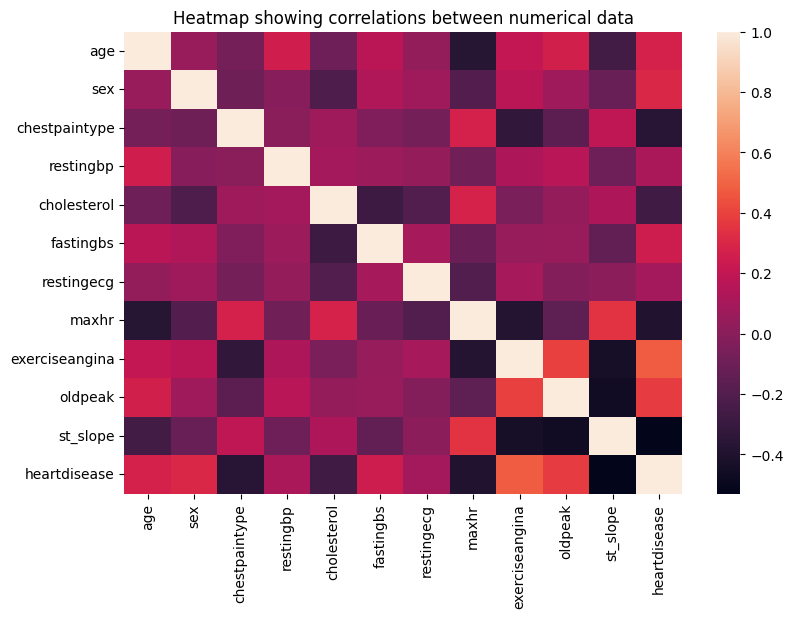

In [31]:
plt.figure(figsize=(9, 6))
sns.heatmap(data_numeric.corr())
plt.title('Heatmap showing correlations between numerical data')
plt.show();

In [32]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

# One Hot Encoding

In [33]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Logistic Regression

In [34]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

LogisticRegression()

In [35]:
y_pred = model.predict_proba(X_val)[:, 1]

In [36]:
heartdisease_decision = (y_pred >= 0.5)

In [37]:
(y_val == heartdisease_decision).mean()

0.8478260869565217

In [38]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = heartdisease_decision.astype(int)
df_pred['actual'] = y_val
df_pred

,probability,prediction,actual
0,0.852775,1,1
1,0.918245,1,0
2,0.783835,1,1
3,0.573532,1,1
4,0.923653,1,1
...,...,...,...
179,0.569053,1,0
180,0.989933,1,1
181,0.973037,1,1
182,0.230559,0,0


# Logistic Regression Score

In [39]:
roc_auc_score(y_val, y_pred)

0.9117228286663502

# Decision Tree 

In [40]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [41]:
scores = []
depths = [4,5,6]

for depth in depths: 
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        x_dict = df_train.to_dict(orient='records')
        dv= DictVectorizer(sparse=False)
        x_train = dv.fit_transform(x_dict)
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(x_train, y_train)
        val_dicts = df_val.to_dict(orient='records')
        x_val = dv.transform(val_dicts)
        y_pred = dt.predict_proba(x_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

In [42]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [43]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.863  0.855  0.847
5                 0.873  0.884  0.877
10                0.876  0.874  0.882
15                0.874  0.880  0.881
20                0.872  0.872  0.868
100               0.801  0.801  0.801
200               0.742  0.742  0.742
500               0.500  0.500  0.500

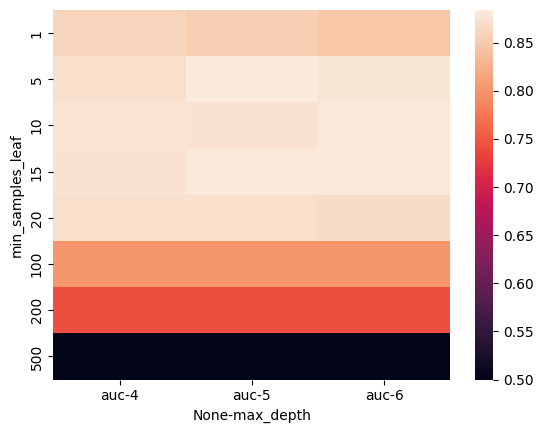

In [44]:
sns.heatmap(df_scores_pivot, fmt=".3f");

In [45]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

# Decision Tree Score

In [46]:
val_dicts = df_val.to_dict(orient='records')
x_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.8771357380161366

# Random Forest Classifier

In [47]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [48]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [49]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [50]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth        5      10     15
n_estimators                     
10            0.897  0.880  0.893
20            0.895  0.887  0.906
30            0.901  0.899  0.908
40            0.901  0.902  0.909
50            0.905  0.906  0.910
60            0.905  0.909  0.909
70            0.904  0.908  0.911
80            0.906  0.908  0.910
90            0.906  0.908  0.911
100           0.908  0.909  0.911
110           0.907  0.909  0.910
120           0.906  0.908  0.909
130           0.906  0.910  0.910
140           0.906  0.909  0.909
150           0.906  0.910  0.909
160           0.906  0.910  0.910
170           0.906  0.910  0.909
180           0.906  0.909  0.909
190           0.906  0.910  0.911
200           0.906  0.910  0.911

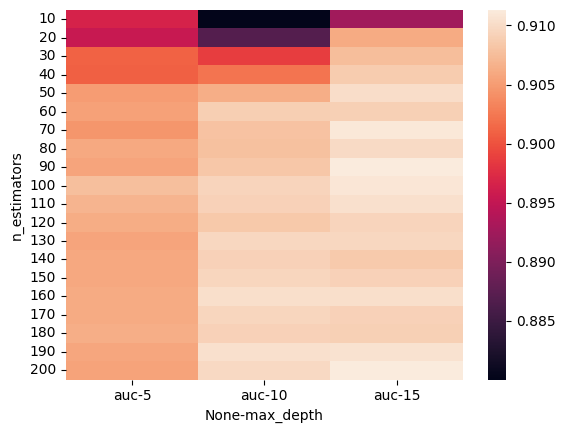

In [51]:
sns.heatmap(df_scores_pivot, fmt=".3f");

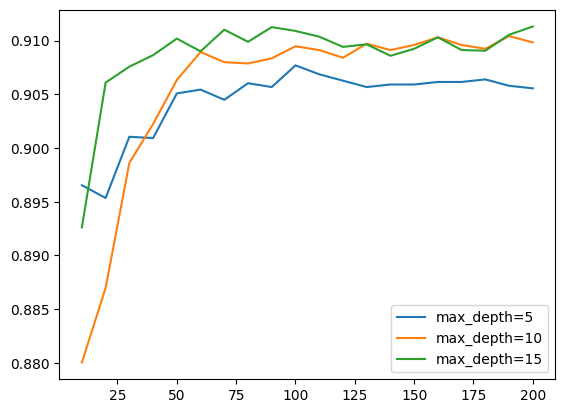

In [52]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend();

In [53]:
max_depth = 15

In [54]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [55]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

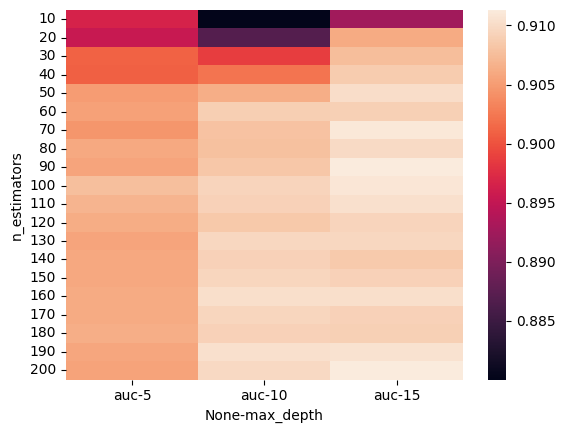

In [56]:
sns.heatmap(df_scores_pivot, fmt=".3f");

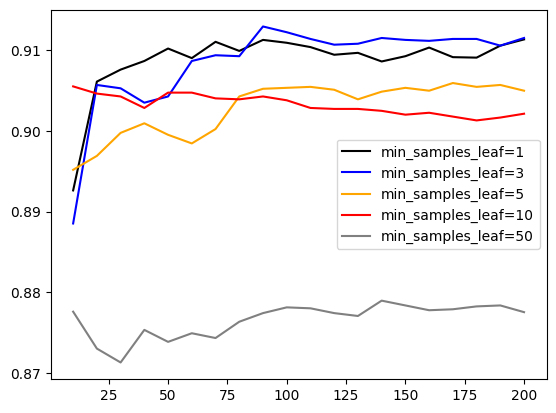

In [57]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend();

In [58]:
min_samples_leaf = 3

In [59]:
scores = []
for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [60]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [61]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,random_state=1)

rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

# Random Forest Score

In [62]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.911485524442335

# Gradient boosting and XGBoost

In [63]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [64]:
x_dict = df_train.to_dict(orient='records')
dv= DictVectorizer(sparse=False)
x_train = dv.fit_transform(x_dict)
val_dicts = df_val.to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [65]:
features = dv.get_feature_names_out()
features

array(['age', 'chestpaintype=ASY', 'chestpaintype=ATA',
       'chestpaintype=NAP', 'chestpaintype=TA', 'cholesterol',
       'exerciseangina=N', 'exerciseangina=Y', 'fastingbs', 'maxhr',
       'oldpeak', 'restingbp', 'restingecg=LVH', 'restingecg=Normal',
       'restingecg=ST', 'sex=F', 'sex=M', 'st_slope=Down',
       'st_slope=Flat', 'st_slope=Up'], dtype=object)

In [66]:
features = dv.get_feature_names_out()
features = features.tolist()
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

In [67]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [68]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8970099667774085

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [70]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10,
                  verbose_eval=5,
                  evals=watchlist)
y_pred = model.predict(dval)

# Gradient boosting and XGBoost Score

In [71]:
roc_auc_score(y_val, y_pred)

0.8970099667774085

In [72]:
s = output.stdout

In [73]:
print(s[:200])

[0]	train-auc:0.95102	val-auc:0.87631
[5]	train-auc:0.98991	val-auc:0.88805
[9]	train-auc:0.99541	val-auc:0.89701



In [74]:
def parse(output):
    scores = []
    for line in output.stdout.strip().split('\n'):
            a,b,c = line.split('\t')
            itr = int(a.strip('[]'))
            train = float(b.split(':')[1])
            val = float(c.split(':')[1])
            
            scores.append((itr,train,val))
    columns = ['iteration','train_auc','val_auc']
    df_scores = pd.DataFrame(scores,columns=columns)
    return df_scores

In [75]:
df_score = parse(output)

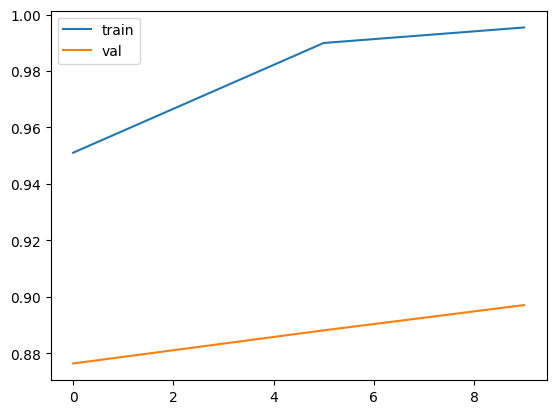

In [76]:
plt.plot(df_score.iteration, df_score.train_auc, label='train')
plt.plot(df_score.iteration, df_score.val_auc, label='val')
plt.legend();

In [77]:
def final_train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(dicts)

    model =LogisticRegression(solver='lbfgs')
    model.fit(x_train, y_train)
    
    return dv, model


def final_predict(df_test, dv, model):
    dicts = df_test.to_dict(orient='records')

    x_test = dv.transform(dicts)
    y_pred = model.predict_proba(x_test)[:, 1]

    return y_pred

In [78]:
dv, model = final_train(df_full_train, df_full_train.heartdisease.values, C=1.0)
y_pred = final_predict(df_test, dv, model)

In [79]:
dv, model,y_pred

(DictVectorizer(sparse=False),
 LogisticRegression(),
 array([0.0307553 , 0.06537364, 0.10107953, 0.11774189, 0.10800161,
        0.01152294, 0.02968033, 0.01850221, 0.00348691, 0.05597918,
        0.00583541, 0.04093303, 0.02947475, 0.08848459, 0.05649997,
        0.00569331, 0.11170878, 0.00906147, 0.12624104, 0.06573996,
        0.05060579, 0.00384789, 0.1480272 , 0.00392683, 0.04658428,
        0.06178611, 0.02002091, 0.06227891, 0.04754403, 0.00750029,
        0.00397516, 0.01141198, 0.01181198, 0.00403013, 0.11184241,
        0.14493522, 0.08572146, 0.15658897, 0.00499773, 0.01900655,
        0.06448702, 0.06894632, 0.08832377, 0.03018769, 0.00390633,
        0.00384675, 0.10805541, 0.01019915, 0.00668095, 0.07167736,
        0.0067776 , 0.10374594, 0.23368948, 0.01057534, 0.06429625,
        0.01104826, 0.09020229, 0.00617037, 0.05063828, 0.01429305,
        0.17257731, 0.041715  , 0.03227917, 0.0231315 , 0.01080884,
        0.10037115, 0.10075446, 0.07466513, 0.00428424, 0.1204

In [80]:
output_file =  'mid_term_model'

In [81]:
with open(output_file,'wb')as f_out:
    pickle.dump((dv,model),f_out)
print(f'the model is saved to {output_file}')

the model is saved to mid_term_model
